In [71]:
# load pickle file
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("..")
from architecture import VGG16_BN

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## Figure 2: (a) Sorting filters by absolute weights sum for each layer of VGG-16 on CIFAR-10

In [72]:
# load best model's parameter
model = VGG16_BN()
checkpoint = torch.load('../vgg16_baseline_exp1/checkpoint/best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)

colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
lines = ['-', '--', '-.']

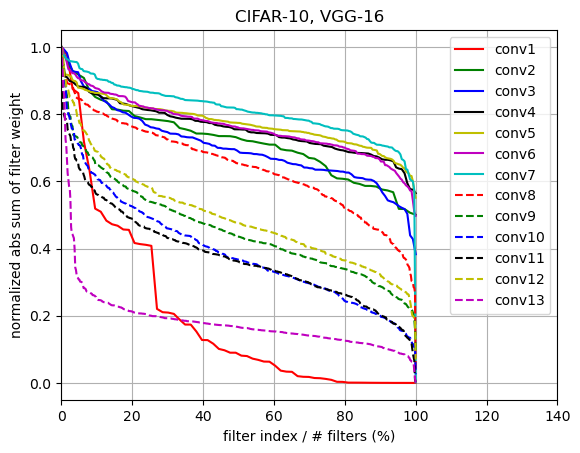

In [73]:
# visualization
## set x data (filter index / # filters (%))
## The y-axis is the filter weight sum divided by the max sum value among filters in that layer.

# plt.figure(figsize=(7, 5))
num_conv_layers = 0

for layer in model.modules() :
    if isinstance(layer, torch.nn.Conv2d) :
        # check filter shape
        # print(f"conv{num_conv_layers + 1} ----------------------")
        filter = layer.weight.data.cpu().numpy()
        # print(f"filter.shape : {filter.shape}") 
        # L1 norm sorting
        sorted_filter = np.sort(np.sum(np.abs(filter), axis=(1, 2, 3)))[::-1]
        # print(f"sorted_filter.shape : {sorted_filter.shape}")
        # filter weight sum divided by the max sum value
        normalized_sorted_filter = sorted_filter / sorted_filter[0]
        # plot
        line_style = colors[num_conv_layers % len(colors)] + lines[num_conv_layers // len(colors)]
        plt.plot(np.linspace(0, 100, normalized_sorted_filter.shape[0]), normalized_sorted_filter, line_style, label=f"conv{num_conv_layers + 1}")
        
        num_conv_layers += 1

    
plt.title("CIFAR-10, VGG-16")
plt.xlabel("filter index / # filters (%)")
plt.ylabel("normalized abs sum of filter weight")
plt.xlim([0, 140])
plt.grid()
plt.legend(loc='upper right')

plt.savefig("../Figure2/a.png")

# Figure 2: (b) Prune the smallest filters

In [74]:
with open('../Figure2/b/top1_acc_list.pkl', 'rb') as f:
    top1_acc_list = pickle.load(f)
with open('../Figure2/b/top5_acc_list.pkl', 'rb') as f:
    top5_acc_list = pickle.load(f)
    
print(top1_acc_list)
print(top5_acc_list)

{0: [91.9, 91.9, 91.9, 91.79, 91.85, 91.54, 90.7, 89.57, 68.69, 51.6], 1: [91.54, 90.2, 88.97, 80.37, 70.66, 52.1, 47.1, 25.57, 14.72, 10.22], 2: [91.56, 91.01, 90.57, 88.93, 83.07, 70.71, 38.31, 16.64, 13.56, 10.91], 3: [91.19, 89.96, 87.53, 81.2, 71.79, 52.62, 39.51, 23.39, 13.66, 10.78], 4: [91.29, 89.71, 88.06, 85.31, 79.52, 69.9, 50.29, 27.67, 14.99, 11.19], 5: [91.4, 90.88, 89.8, 87.05, 85.47, 82.5, 77.8, 64.94, 39.21, 21.55], 6: [91.69, 90.76, 89.69, 88.4, 86.53, 81.62, 73.93, 58.28, 34.32, 20.4], 7: [91.7, 91.49, 91.11, 90.76, 89.9, 88.72, 85.44, 79.77, 52.13, 34.11], 8: [91.91, 91.84, 91.73, 91.62, 91.38, 91.22, 89.82, 86.78, 68.72, 55.3], 9: [91.91, 91.82, 91.81, 91.72, 91.58, 91.43, 91.3, 90.99, 88.37, 75.41], 10: [91.9, 91.94, 91.89, 91.82, 91.87, 91.83, 91.76, 91.67, 91.12, 86.08], 11: [91.93, 91.84, 91.87, 91.89, 91.84, 91.75, 91.55, 91.17, 53.6, 15.27], 12: [91.89, 91.88, 91.82, 91.79, 91.69, 91.43, 90.63, 78.38, 35.6, 23.21]}
{0: [99.42, 99.42, 99.43, 99.42, 99.38, 99.3

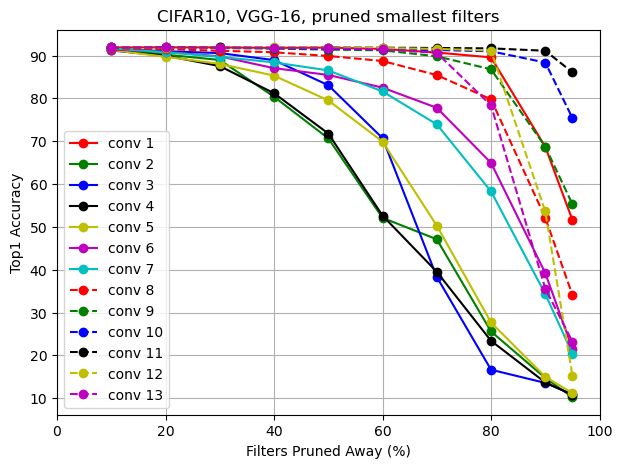

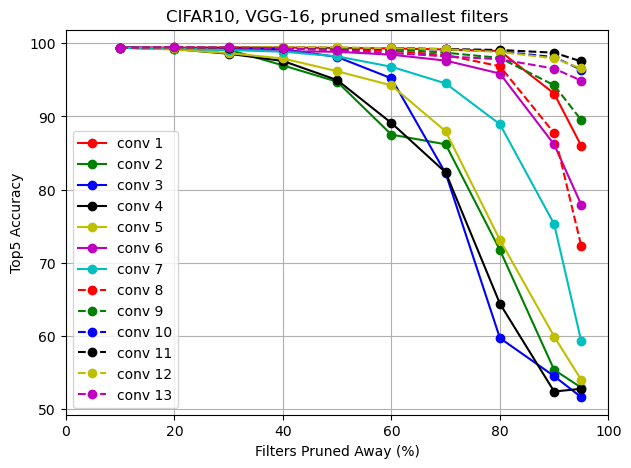

In [75]:
num_conv_layers = 0
colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
lines = ['-', '--', '-.']
x_data = [10, 20, 30, 40, 50, 60, 70, 80, 90, 95]

plt.figure(figsize=(7,5))
for index, (key, value) in enumerate(top1_acc_list.items()):
    line_style = colors[index%len(colors)] + lines[index//len(colors)] +'o'
    plt.plot(x_data, value, line_style, label=f"conv {key+1}")

plt.title("CIFAR10, VGG-16, pruned smallest filters")        
plt.ylabel("Top1 Accuracy")
plt.xlabel("Filters Pruned Away (%)")
plt.legend(loc='lower left')
plt.grid()
plt.xlim(0, 100)
plt.savefig("../Figure2/b/top1_acc.png", dpi=150, bbox_inches='tight')
plt.show()       

plt.figure(figsize=(7,5))
for index, (key, value) in enumerate(top5_acc_list.items()):
    line_style = colors[index%len(colors)] + lines[index//len(colors)] +'o'
    plt.plot(x_data, value, line_style, label=f"conv {key+1}")

plt.title("CIFAR10, VGG-16, pruned smallest filters")
plt.ylabel("Top5 Accuracy")
plt.xlabel("Filters Pruned Away (%)")
plt.legend(loc='lower left')
plt.grid()
plt.xlim(0, 100)
plt.savefig("../Figure2/b/top5_acc.png", dpi=150, bbox_inches='tight')
plt.show()                


# Figure 2: (c) Prune and retrain

## Epoch 40

In [76]:
with open('../Figure2/c/top1_acc_list_epoch40.pkl', 'rb') as f:
    top1_acc_list = pickle.load(f)
with open('../Figure2/c/top5_acc_list_epoch40.pkl', 'rb') as f:
    top5_acc_list = pickle.load(f)
    
print(top1_acc_list)
print(top5_acc_list)

{0: [91.76, 91.87, 91.84, 91.85, 91.84, 91.85, 91.53, 91.55, 91.15, 90.98], 1: [91.82, 91.58, 91.53, 91.63, 91.28, 91.16, 90.99, 90.89, 89.32, 85.44], 2: [91.79, 91.64, 91.68, 91.51, 91.4, 91.54, 91.11, 91.09, 90.54, 89.76], 3: [91.82, 91.71, 91.64, 91.24, 91.08, 91.11, 90.89, 90.37, 89.2, 87.26], 4: [91.67, 91.62, 91.49, 91.33, 91.51, 91.22, 91.06, 90.83, 89.89, 89.5], 5: [91.74, 91.59, 91.42, 91.47, 91.18, 91.14, 91.41, 90.96, 90.38, 89.45], 6: [91.76, 91.6, 91.43, 91.49, 91.08, 90.96, 91.48, 90.65, 90.14, 89.62], 7: [91.71, 91.64, 91.77, 91.55, 91.75, 91.44, 91.3, 91.39, 91.14, 91.06], 8: [91.82, 91.68, 91.71, 91.9, 91.77, 91.65, 91.63, 91.59, 91.77, 91.82], 9: [91.84, 91.86, 91.8, 91.82, 91.73, 91.78, 91.82, 91.76, 91.71, 91.71], 10: [91.78, 91.74, 91.88, 91.82, 91.86, 91.83, 91.75, 91.87, 91.82, 91.76], 11: [91.92, 91.81, 91.89, 91.76, 91.75, 91.76, 91.78, 91.87, 91.86, 91.78], 12: [91.89, 91.76, 91.8, 91.84, 91.88, 91.83, 91.87, 91.76, 91.81, 91.83]}
{0: [99.43, 99.38, 99.36, 99.

In [77]:
# delete first index of each list
for key, value in top1_acc_list.items():
    top1_acc_list[key] = value[1:]
for key, value in top5_acc_list.items():
    top5_acc_list[key] = value[1:]
    
    

print(top1_acc_list)
print(top5_acc_list)

{0: [91.87, 91.84, 91.85, 91.84, 91.85, 91.53, 91.55, 91.15, 90.98], 1: [91.58, 91.53, 91.63, 91.28, 91.16, 90.99, 90.89, 89.32, 85.44], 2: [91.64, 91.68, 91.51, 91.4, 91.54, 91.11, 91.09, 90.54, 89.76], 3: [91.71, 91.64, 91.24, 91.08, 91.11, 90.89, 90.37, 89.2, 87.26], 4: [91.62, 91.49, 91.33, 91.51, 91.22, 91.06, 90.83, 89.89, 89.5], 5: [91.59, 91.42, 91.47, 91.18, 91.14, 91.41, 90.96, 90.38, 89.45], 6: [91.6, 91.43, 91.49, 91.08, 90.96, 91.48, 90.65, 90.14, 89.62], 7: [91.64, 91.77, 91.55, 91.75, 91.44, 91.3, 91.39, 91.14, 91.06], 8: [91.68, 91.71, 91.9, 91.77, 91.65, 91.63, 91.59, 91.77, 91.82], 9: [91.86, 91.8, 91.82, 91.73, 91.78, 91.82, 91.76, 91.71, 91.71], 10: [91.74, 91.88, 91.82, 91.86, 91.83, 91.75, 91.87, 91.82, 91.76], 11: [91.81, 91.89, 91.76, 91.75, 91.76, 91.78, 91.87, 91.86, 91.78], 12: [91.76, 91.8, 91.84, 91.88, 91.83, 91.87, 91.76, 91.81, 91.83]}
{0: [99.38, 99.36, 99.4, 99.36, 99.46, 99.45, 99.37, 99.44, 99.34], 1: [99.41, 99.51, 99.45, 99.36, 99.34, 99.38, 99.35,

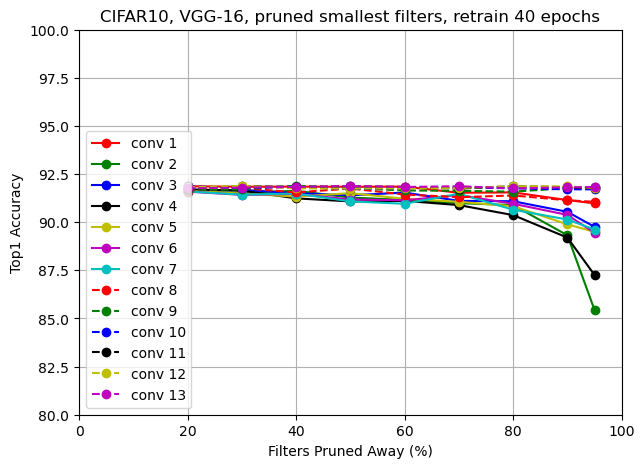

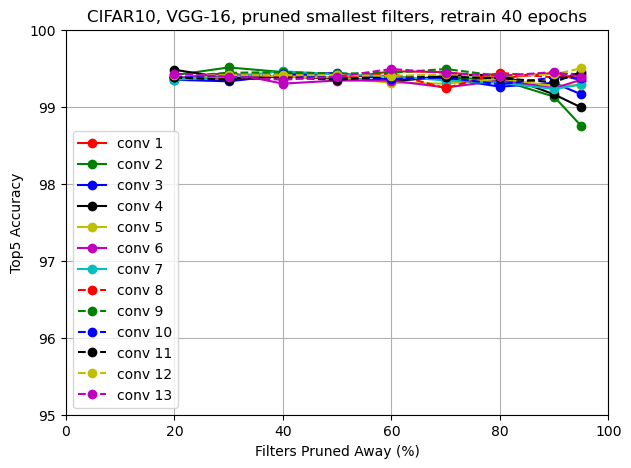

In [78]:
num_conv_layers = 0
colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
lines = ['-', '--', '-.']
x_data = [20, 30, 40, 50, 60, 70, 80, 90, 95]

plt.figure(figsize=(7,5))

for index, (key, value) in enumerate(top1_acc_list.items()):
    line_style = colors[index%len(colors)] + lines[index//len(colors)] +'o'
    plt.plot(x_data, value, line_style, label=f"conv {key+1}")
    
plt.title("CIFAR10, VGG-16, pruned smallest filters, retrain 40 epochs")
plt.ylabel("Top1 Accuracy")
plt.xlabel("Filters Pruned Away (%)")
plt.legend(loc='lower left')
plt.grid()
plt.xlim(0, 100)
# y limit 10 ~ 100
plt.ylim(80, 100)
plt.savefig("../Figure2/c/top1_acc.png", dpi=150, bbox_inches='tight')
plt.show()

plt.figure(figsize=(7,5))
for index, (key, value) in enumerate(top5_acc_list.items()):
    line_style = colors[index%len(colors)] + lines[index//len(colors)] +'o'
    plt.plot(x_data, value, line_style, label=f"conv {key+1}")

plt.title("CIFAR10, VGG-16, pruned smallest filters, retrain 40 epochs")
plt.ylabel("Top5 Accuracy")
plt.xlabel("Filters Pruned Away (%)")
plt.legend(loc='lower left')
plt.grid()
plt.xlim(0, 100)
# y limit 88 ~ 94
plt.ylim(95, 100)

plt.savefig("../Figure2/c/top5_acc.png", dpi=150, bbox_inches='tight')
plt.show()

## Epoch 20